# Twitter Airline Sentiment Analysis (ULMFiT)

## Introduction

This notebook explores the [Twitter US Airline Sentiment Dataset](https://www.kaggle.com/crowdflower/twitter-airline-sentiment) and tries to predict tweet sentiment using a language model and RNN via Fast.ai's library for Universal Language Model Fine-tuning for Text Classification ([ULMFiT](http://nlp.fast.ai/classification/2018/05/15/introducting-ulmfit.html)).

## Setup

Importing packages.

In [204]:
# Basic packages
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt

# Modeling, selection, and evaluation
from fastai.text import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils.multiclass import unique_labels

%matplotlib inline 

## Data Preparation

First we read in the data and have a look at the columns we can use and explore. 

In [33]:
# Read file into dataframe
pd.set_option('display.max_colwidth', -1)
df = pd.read_csv('./Tweets.csv')
df = df.reindex(np.random.permutation(df.index))  
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
11617,567874261085454338,negative,1.0000,Late Flight,1.0000,US Airways,NaN,pdotts4,NaN,0,"@USAirways how about an update? 2hrs delayed, this obviously isnt up 2 date, havent boarded http://t.co/L7lWjaZiOA",NaN,2015-02-17 18:32:29 -0800,"Atlanta, GA",NaN
12265,570248011621609472,negative,1.0000,Late Flight,1.0000,American,NaN,dwjudson,NaN,0,@AmericanAir The pilot admitted to us that this delay is entirely because of AA incompetence and poor equip checks.,NaN,2015-02-24 07:44:55 -0800,"Toronto, Ontario, Canada",Eastern Time (US & Canada)
14455,569613601918492672,neutral,1.0000,NaN,NaN,American,NaN,CoryStinebrink,NaN,0,@AmericanAir hey guys. DMed you a question about when 500-mile upgrades post after earning. Hope to use tomorrow,NaN,2015-02-22 13:44:00 -0800,"Madison, WI",Central Time (US & Canada)
6045,568418531777355776,negative,1.0000,Late Flight,1.0000,Southwest,NaN,iammmadeux,NaN,0,@SouthwestAir why the delay on Flight 423 BDL to MCO? Need to get to Florida for the ☀️&amp; races in Daytona,NaN,2015-02-19 06:35:13 -0800,CT,Eastern Time (US & Canada)
13197,569916590814203904,negative,0.6397,Can't Tell,0.3567,American,NaN,sindhurella67,NaN,0,"@AmericanAir followed. I tried to @USAirways record locator number, gave me an error code","[32.78951797, -96.79891462]",2015-02-23 09:47:58 -0800,NaN,Eastern Time (US & Canada)


Next we look at the distribution of the main dependent variable: airline_sentiment, and its breakdown across airlines and tweet length. 

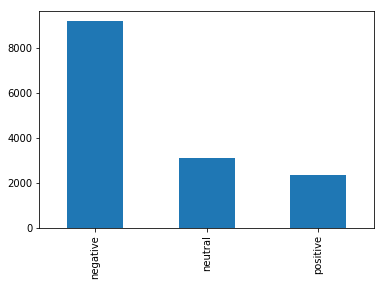

In [32]:
df['airline_sentiment'].value_counts().plot(kind='bar')

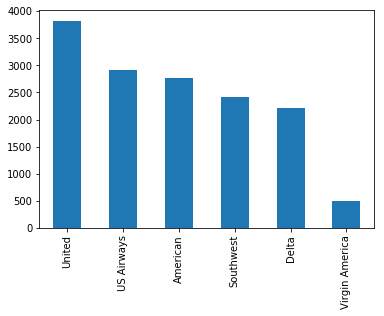

In [34]:
df['airline'].value_counts().plot(kind='bar')

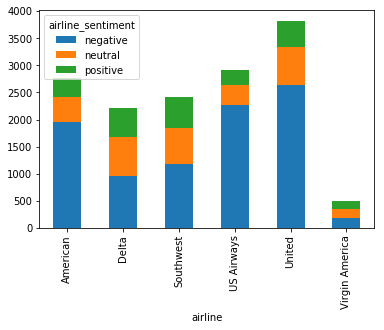

In [41]:
df.groupby(['airline', 'airline_sentiment']).size().unstack().plot(kind='bar', stacked=True)

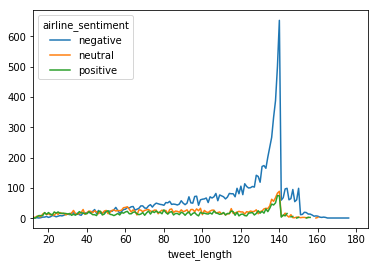

In [48]:
df['tweet_length'] = df['text'].apply(len)
df.groupby(['tweet_length', 'airline_sentiment']).size().unstack().plot(kind='line', stacked=False)

We see that there isn't a lot of correlation between the number of positive / neutral tweets and the tweet length, but for negative tweets the distribution is heavily skewed towards longer tweets. This is possibly because the angier the tweeter, the more they have to say. Next we'll see if the same observation can be made about the average and median sentiment confidence as well.

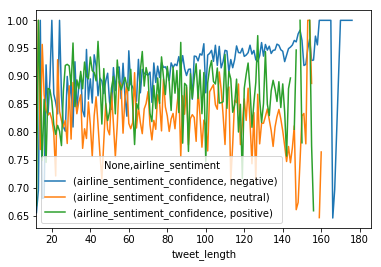

In [51]:
df[['tweet_length', 'airline_sentiment', 'airline_sentiment_confidence']].groupby(['tweet_length', 'airline_sentiment']).mean().unstack().plot(kind='line', stacked=False)

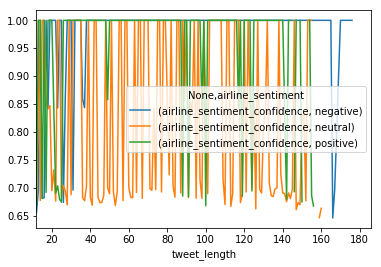

In [52]:
df[['tweet_length', 'airline_sentiment', 'airline_sentiment_confidence']].groupby(['tweet_length', 'airline_sentiment']).median().unstack().plot(kind='line', stacked=False)

There doesn't seem to be a discernable relationship between the confidence and the tweet length. Next we randomize and split the data, then write to CSVs. 

In [160]:
test_percentage = 0.1
df.sort_index(inplace=True)
cutoff = int(test_percentage * df.shape[0])
df[['airline_sentiment', 'text']][:cutoff].to_csv('Tweets_filtered_test.csv', index=False, encoding='utf-8')
df[['airline_sentiment', 'text']][cutoff:].to_csv('Tweets_filtered_train.csv', index=False, encoding='utf-8')
df[['text']][cutoff:].to_csv('Tweets_text_only_train.csv', index=False, encoding='utf-8')

### Tokenization

We read in the data and add new words to our dictionary, as well as create a representation of words using numbers. 

In [162]:
data = TextClasDataBunch.from_csv('.', 'Tweets_filtered_train.csv')
data.show_batch()

text,target
xxbos @united xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup dub - xxup jac 29 / 9 xxup jac - xxup lax 8 / 10 xxup lax - xxup dub 13 / 10 . i 'm * xxup xxunk xxmaj what is checked bag allowance for xxup jac - xxup lax ?,neutral
"xxbos @united xxmaj waiting for xxunk xxup ewr - xxup ord , delayed 47 mins . xxmaj might miss xxunk xxup ord - xxup xxunk at 6 pm xxup ct . xxmaj any room on xxunk xxup ord - xxup xxunk in case i miss xxunk ?",negative
xxbos @usairways i left an item on plane xxup bos - xxup phl on xxmaj friday . i 've called xxup phl xxup us xxmaj airways # & & left 6 xxunk . xxmaj no return call what to do at this point .,negative
xxbos @jetblue xxmaj flight 136 departs xxunk xxup am xxmaj finally ! ! ! xxmaj arrived xxup jfk with no xxunk at xxunk xxup pm . xxmaj that 's a long flight . xxup aka xxup bus http : / / t.co / xxunk,negative
xxbos @americanair xxmaj need to go frm xxup tpa to xxup mci tmrw & & my connection thru xxup dfw is xxmaj cancelled xxmaj flightled . xxmaj can u connect me thru a diff city ? xxmaj been on hold for 2 hrs,negative


The following changes have been made to the text for ease of modeling:
- split on space and punctuation symbols
- the "'s" are grouped together in one token
- the contractions are separated like this: "did", "n't"
- there are several special tokens (all those that begin by xx), to replace unknown tokens (see below)

In [163]:
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '.',
 'to']

Looking into the dataset we can now see the current representation post-processing, in both text form and numerical.

In [164]:
print(data.train_ds[0][0])
print(data.train_ds[1][0])
print(data.train_ds[2][0])

xxbos @usairways how is your gate agent gon na tell me my flight is on time when its 5 minutes past departure time and the previous flights plane ..
xxbos @americanair my flight xxunk was xxmaj cancelled xxmaj flightled and i need to get back to xxmaj cleveland . xxmaj what are my options ?
xxbos @jetblue - i will for sure . xxmaj but my xxup tsa - xxmaj pre works with other airlines . xxmaj why is xxmaj jetblue different ?


In [165]:
print(data.train_ds[0][0].data[:10])
print(data.train_ds[1][0].data[:10])
print(data.train_ds[2][0].data[:10])

[  2  24  86  27  38 101 177 859 835 291]
[  2  25  23  19   0  39   4  58   4 102]
[  2  30  44  10  73  18 236   8   4  51]


## Language Model

We'll be using a language model provided from the fastai library and applying the pre-calculated weights from wikitext-103. This will provide a word embedding scheme that aligns with the corpus of airline tweets and will hopefully capture sufficient "meaning" in each word. The language model here will not be optimal as tweets sometimes do not obey conventional spelling and grammar, especially hastags. 

In [166]:
bs = 24
seed = 333

First we ingest the data once again but have a 10% holdout only since we'll be using it to calibrate the language model. 

In [167]:
data_lm = (TextList.from_csv('.', 'Tweets_text_only_train.csv')
            .random_split_by_pct(0.1, seed = seed)
           #We randomly split and keep 10% for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('data_lm.pkl')

In [168]:
# data_lm = load_data(path, 'data_lm.pkl', bs=bs)
data_lm.show_batch()

idx,text
0,xxbos xxmaj xxunk xxup rt @jetblue : xxmaj our fleet 's on fleek . http : / / t.co / xxunk xxbos @usairways xxmaj was told it was a software bug . xxmaj told to call back this xxup am xxmaj now your system is too busy to handle any calls this xxup am . xxmaj xxunk shoes . xxbos @jetblue thank you ! ! xxbos @americanair origin / destination
1,flight dealing with xxmaj cancelled xxmaj flightlations and weather xxunk . xxmaj those are more important . i know you will respond . xxbos @southwestair my golf bag was broken on the flight i just took . xxmaj what 's the process for damage reimbursement ? xxbos @united thanks for reminding me how much easier it is to fly xxmaj southwest ! xxmaj get more agents at sfo 25 !
2,"suggestion . i checked and we were not rebooked . xxmaj we 'll keep checking and looking for other flights xxbos @southwestair xxunk that just made my day . i looked and just could n't find that , thank you ! xxbos @usairways direct flights to xxup sfo leaving from same airport with @virginamerica and @united - can you please put me on one of those ? xxbos @americanair probably"
3,"was lost / stolen . customer service 👎 xxbos @usairways i 've been on hold for over an hour . xxmaj not doing so well in the customer service department . # weak xxbos @jetblue : xxmaj xxunk from a loyal # xxunk holder ! xxmaj when do you anticipate direct xxup us flights to # xxmaj xxunk , # xxmaj cuba ? ( # jetblue # xxmaj vacation )"
4,"delay on my first flight . xxbos @united xxmaj still do not have my bag , it 's in the xxup clt airport . xxmaj was originally told i would have it by 2 pm . xxbos @americanair xxmaj hi xxup aa ! i placed an xxunk on hold to expire on 2 / xxunk logged into my acct .. its gone ! xxmaj seat has n't been released to"


Now we define the language model and set the learning rates. 

In [169]:
learn = language_model_learner(data_lm, "AWD_LSTM", pretrained_model=URLs.WT103_1, drop_mult=0.3)

In [170]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


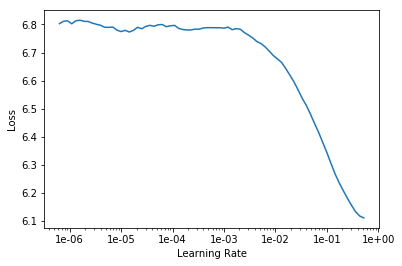

In [171]:
learn.recorder.plot(skip_end=15)

Next we fit the model for a few cycles by running 1 epoch and then unfreezing and running more epochs to fine tune.  

In [172]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,4.286326,3.917804,0.255885


In [173]:
learn.save('fit_head')
# learn.load('fit_head')

In [174]:
learn.unfreeze()

In [175]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,3.916371,3.798578,0.274872
2,3.778026,3.685494,0.287350
3,3.634296,3.619393,0.291108
4,3.456076,3.557787,0.300634
5,3.255001,3.556257,0.299728
6,3.080054,3.551021,0.303990
7,2.892407,3.570565,0.304429
8,2.760429,3.598356,0.300741
9,2.661657,3.615303,0.301767
10,2.634488,3.622445,0.300814


In [178]:
learn.save('fine_tuned')

In [179]:
learn.save_encoder('fine_tuned_enc')

The language model is a bit worse than I would have expected; this is likely due to the fact that tweets dont always follow proper English spelling and grammar, making it difficult for the model to correctly predict. 

## Classifier

Next we'll use the encoder from the language model in our classifier, which uses a similar LSTM architecture but will predict the sentiment instead of the next word in a tweet. The LSTM model here presents some advantages over traditional bags-of-words models as it's able to encode some "meaning" in the sequential nature of the words in the tweet. 

In [180]:
data_clas = (TextList.from_csv('.', 'Tweets_filtered_train.csv', cols = 'text')               
             .random_split_by_pct(0.1, seed = seed)
             .label_from_df(cols=0)
             .databunch(bs=bs))
data_clas.save('data_clas.pkl')
data_clas.show_batch()

text,target
xxbos @united xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup xxunk - xxup jac 29 / 9 xxup jac - xxup lax 8 / 10 xxup lax - xxup xxunk 13 / 10 . i 'm * xxup xxunk xxmaj what is checked bag allowance for xxup jac - xxup lax ?,neutral
xxbos @usairways xxmaj my xxmaj flight xxmaj booking xxmaj problems xxup xxunk just times out when i select it under xxmaj manage xxmaj my xxmaj flight xxmaj booking xxmaj problems for months now . i have emailed but no response . xxmaj help ?,negative
xxbos @united xxmaj missed xxup xxunk flight due to ur xxmaj cancelled xxmaj flightlation . xxmaj xxunk supervisor disgusting . xxmaj now day xxmaj late xxmaj flight . xxmaj no apology or upgrade offer to xxup lhr from xxup ord ? ? ?,negative
xxbos @usairways i 've been on hold for over 2 1 / 2 hours - there has to be an easier way to xxmaj cancelled xxmaj flight / get a refund ... 😑 😩 http : / / t.co / xxunk,negative
"xxbos @southwestair xxmaj hi ! xxmaj winter xxmaj xxunk xxmaj advisory issued for xxup stl . xxmaj snow & & xxmaj ice & & xxmaj cold , oh my ! xxmaj will you issue a travel advisory for that ?",neutral


In [181]:
learn = text_classifier_learner(data_clas, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

In [182]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


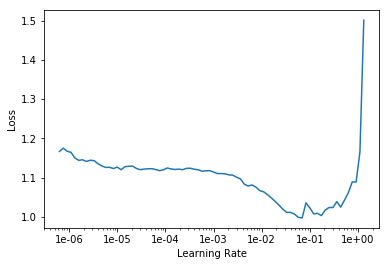

In [183]:
learn.recorder.plot()

We train by gradually unfreezing layers and then running an epoch each time, in accordance with the suggestions in the ULMFiT paper.

In [184]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.654767,0.555961,0.776765


In [185]:
learn.save('first')
# learn.load('first)

In [186]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.665009,0.524128,0.791951


In [192]:
# learn.save('second')
learn.load('second')

RNNLearner(data=TextClasDataBunch;

Train: LabelList
y: CategoryList (11859 items)
[Category negative, Category positive, Category negative, Category neutral, Category neutral]...
Path: .
x: TextList (11859 items)
[Text xxbos @united the delay is due to customer service for 20 people ? xxmaj what about the xxup xxunk - xxup service you provided for 100 + ? # xxunk # xxunk, Text xxbos @united he is so excellent and so reliable :) # happycustomer, Text xxbos @united but again xxup united xxup xxunk xxup give 2 xxup xxunk xxup about xxup their xxup customers, Text xxbos @united xxmaj she is travelling from xxmaj xxunk ( xxmaj australia ) to xxmaj bogota ( xxmaj xxunk ) tomorrow, Text xxbos @united xxmaj hi . xxmaj my relative 's xxmaj flight xxmaj booking xxmaj problems number is xxup xxunk . xxmaj her name is xxmaj xxunk xxmaj xxunk xxmaj xxunk . xxmaj thank you]...
Path: .;

Valid: LabelList
y: CategoryList (1317 items)
[Category negative, Category negative, Category positive, Category 

In [193]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.566623,0.496646,0.797267


In [194]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.570657,0.479095,0.807897
2,0.527614,0.501887,0.818527
3,0.522849,0.480737,0.813971


### Evaluate Performance on Test Set

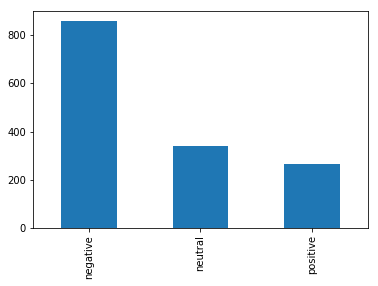

In [253]:
test_df = pd.read_csv("Tweets_filtered_test.csv", encoding="utf-8")
test_df['airline_sentiment'].value_counts().plot(kind='bar')

In [254]:
test_df['pred_sentiment'] = test_df['text'].apply(lambda row: str(learn.predict(row)[0]))
print("Test Accuracy: ", accuracy_score(test_df['airline_sentiment'], test_df['pred_sentiment']))

Test Accuracy:  0.7663934426229508


In [255]:
test_df[:30]

,airline_sentiment,text,pred_sentiment
0,neutral,@VirginAmerica What @dhepburn said.,negative
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.,negative
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!,negative
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",negative
4,negative,@VirginAmerica and it's a really big bad thing about it,negative
5,negative,@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\r\nit's really the only bad thing about flying VA,negative
6,positive,"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)",negative
7,neutral,"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP",negative
8,positive,"@virginamerica Well, I didn't…but NOW I DO! :-D",negative
9,positive,"@VirginAmerica it was amazing, and arrived an hour early. You're too good to me.",positive


Plot confusion matrix to see where the areas of misclassification are. 

In [260]:
# Confusion matrix plotting adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

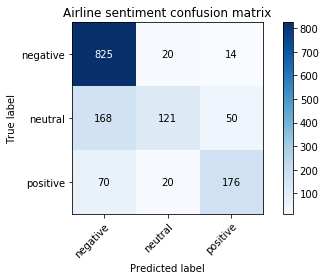

In [259]:
plot_confusion_matrix(test_df['airline_sentiment'], test_df['pred_sentiment'], classes=['negative', 'neutral', 'positive'], title='Airline sentiment confusion matrix')
# confusion_matrix(test_df['airline_sentiment'], test_df['pred_sentiment'], labels=['positive', 'neutral', 'negative'])
plt.show()

From the confusion matrix, we can see that within True Negatives, the prediction accuracy is pretty high. The model has a very hard time classifying neutral tweets, and often misclassifies them as negative. For True Positives, the overall accuracy is pretty good but a surprisingly large number get classified as negative. Let's look at these in closer detail:

In [267]:
test_df.loc[(test_df['airline_sentiment'] == 'positive') & (test_df['pred_sentiment'] == 'negative')]

,airline_sentiment,text,pred_sentiment
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.,negative
6,positive,"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)",negative
8,positive,"@virginamerica Well, I didn't…but NOW I DO! :-D",negative
19,positive,@VirginAmerica you know what would be amazingly awesome? BOS-FLL PLEASE!!!!!!! I want to fly with only you.,negative
47,positive,@VirginAmerica wow this just blew my mind,negative
56,positive,@VirginAmerica you know it. Need it on my spotify stat #guiltypleasures,negative
64,positive,@VirginAmerica @ladygaga @carrieunderwood love all three but you really can't beat the classics!,negative
74,positive,"@VirginAmerica not worried, it's been a great ride in a new plane with great crew. All airlines should be like this.",negative
81,positive,@VirginAmerica I've applied more then once to be a member of the #inflight crew team...Im 100% interested. #flightattendant #dreampath -G,negative
109,positive,"@VirginAmerica has getaway deals through May, from $59 one-way. Lots of cool cities http://t.co/tZZJhuIbCH #CheapFlights #FareCompare",negative


It's not immediately clear what the common thread that led these tweets to be mislabelled but possible causes include missing signals from hastags, non-grammatical sentences, mis-spellings, etc. which generally contribute to the classification error. 

In the future, it would be good to spend more time on feature engineering and fitting the language model so that it's more suited to the vocabulary and style of language that is in tweets. From the language model and processing steps, we can see that the model accuracy is not very high and that, even as humans, it's hard to discern the sentiment from the post-processed / tokenized text. One possible way of addressing this issue is to use a much larger corpus of tweets when developing the language model. 